<a href="https://colab.research.google.com/github/Betovef/Automate-Image-Acquisition/blob/master/PanopticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

## Installing Dependencies

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
#we also need opencv but is already installed in google colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 28.6MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Install Detectron2

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 6.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200704-cp36-none-any.whl size=41894 sha256=8f0c0183eaaab7f2269ebf28ec9a489119e2bf83bb61774312c8f7a3aac8dabe
  Stored in directory: /root/.cache/pip/wheels/fb/d2/8e/b6d0f19811e77dabff1ebed6605ce2b59ee9f487079b434c8c
Successfully built fvcore


## Import Libraries and utilities

In [7]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


# Panoptic Segmentation

## Transform data to coco format

In [55]:
pip install labelme2coco

In [4]:
# import package
import labelme2coco

# set directory that contains labelme annotations and image files
labelme_folder = "/content/validation"

# set path for coco json to be saved
save_json_path = "/content/validation_coco.json"

# convert labelme annotations to coco
labelme2coco.convert(labelme_folder, save_json_path)

## Registering new data-set

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "training_coco.json", "/content/training_coco.json")
register_coco_instances("my_dataset_val", {}, "validation_coco.json", "/content/validation_coco.json")

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/09 04:39:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 70.4MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[07/09 04:39:43 d2.engine.train_loop]: Starting training from iteration 0
[07/09 04:39:48 d2.utils.events]:  eta: 0:01:15  iter: 19  total_loss: 1.766  loss_cls: 0.757  loss_box_reg: 0.248  loss_mask: 0.690  loss_rpn_cls: 0.036  loss_rpn_loc: 0.007  time: 0.2650  data_time: 0.0165  lr: 0.000005  max_mem: 2343M
[07/09 04:39:54 d2.utils.events]:  eta: 0:01:10  iter: 39  total_loss: 1.696  loss_cls: 0.669  loss_box_reg: 0.261  loss_mask: 0.684  loss_rpn_cls: 0.040  loss_rpn_loc: 0.009  time: 0.2680  data_time: 0.0065  lr: 0.000010  max_mem: 2343M
[07/09 04:39:59 d2.utils.events]:  eta: 0:01:03  iter: 59  total_loss: 1.558  loss_cls: 0.539  loss_box_reg: 0.268  loss_mask: 0.676  loss_rpn_cls: 0.039  loss_rpn_loc: 0.009  time: 0.2622  data_time: 0.0054  lr: 0.000015  max_mem: 2343M
[07/09 04:40:04 d2.utils.events]:  eta: 0:00:58  iter: 79  total_loss: 1.457  loss_cls: 0.425  loss_box_reg: 0.333  loss_mask: 0.658  loss_rpn_cls: 0.027  loss_rpn_loc: 0.006  time: 0.2632  data_time: 0.0052  lr:

In [12]:
# Training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

## Loading Images

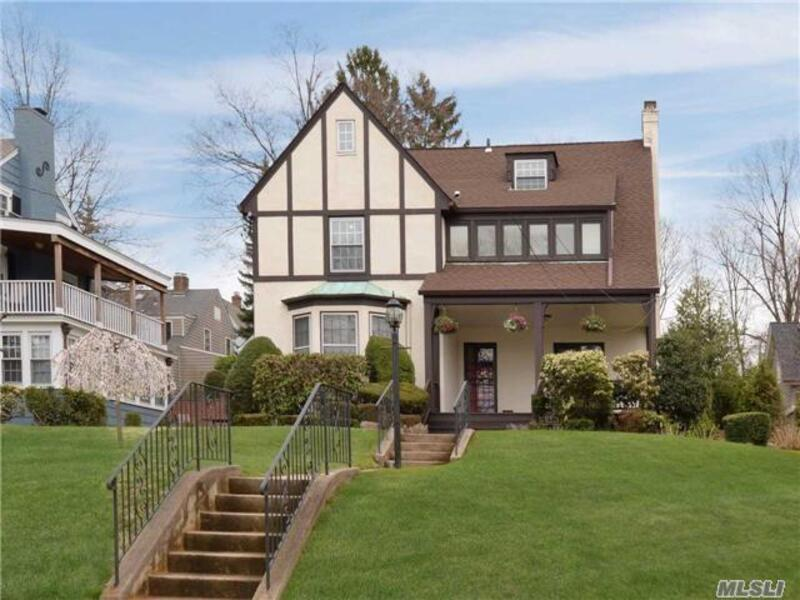

In [15]:
path = '/content/8.jpg'
img = cv2.imread(path) 
cv2_imshow(img)

## Segmentation

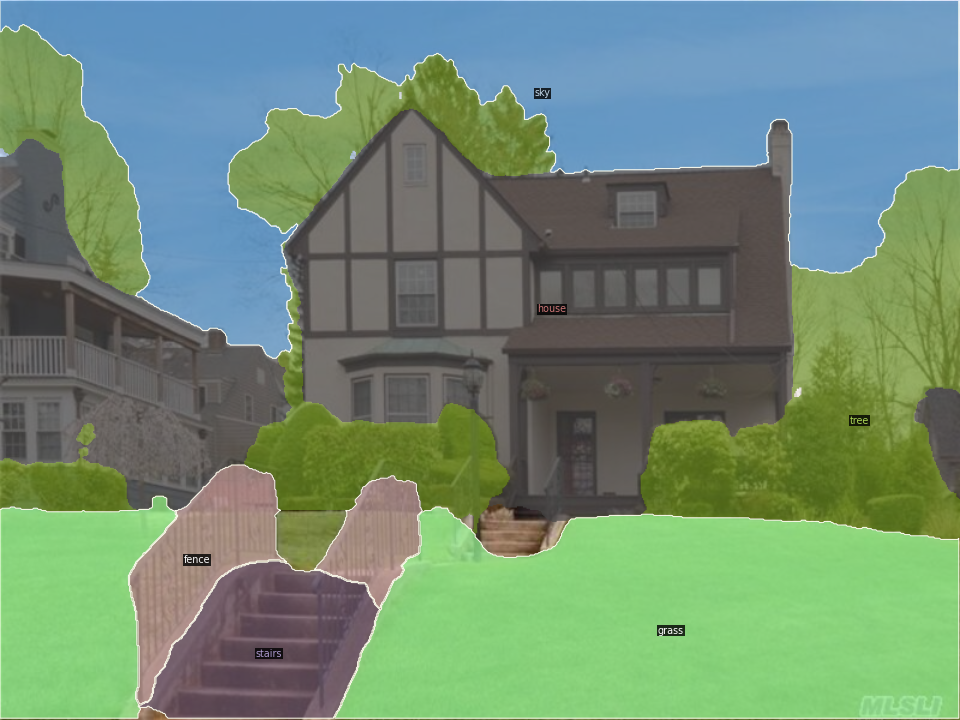

In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])
outputs = predictor(img)

## Get image from the mask


**ISSUE: pred_masks is not defined in panoptic_seg **

In [1]:
masks = outputs["panoptic_seg"].pred_masks.cpu().numpy()
print(pred_masks)

NameError: ignored

In [ ]:
def image_mask(mask, box, img):
  mask_

In [18]:
print(outputs["instances"].pred_masks.cpu())

tensor([], size=(0, 441, 665), dtype=torch.uint8)


# Data extraction 

### Finding the category_id of each mask

In [5]:
print("Segment information: ", segments_info)
print("Categories ids: ")
for data in segments_info:
  print("               ", data.get("category_id"))
  # print(segments_info[i]["category_id"]) is an alternative 


Segment information:  [{'id': 1, 'isthing': False, 'category_id': 12, 'area': 81494.0}, {'id': 2, 'isthing': False, 'category_id': 22, 'area': 13468.0}, {'id': 3, 'isthing': False, 'category_id': 37, 'area': 77386.0}, {'id': 4, 'isthing': False, 'category_id': 40, 'area': 30181.0}, {'id': 5, 'isthing': False, 'category_id': 46, 'area': 84414.0}]
Categories ids: 
                12
                22
                37
                40
                46


## Finding the "stuff" or "thing" corresponding to the category_id

In [10]:
for data in segments_info:
  print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes[data.get("category_id")])

house
roof
tree
sky
grass


## Finding instances and id 

In [19]:
print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [18]:

for data in outputs["instances"].pred_classes:
    num = data.item()
    print(num, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[num])
    

58 potted plant
58 potted plant
13 bench
58 potted plant
